# EmbeddingRandomForest

## Random Forest with Embeddings
So far we have created both a random forest and a NN to do tabular modeling. One thing intresting about a NN is that it contains embeddings. Why don't we try to use these embeddings from the Neural Network in Random Forests? Will it improve the random forest? Lets find out!

In [1]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

## Unzipping data

In [ ]:
import zipfile

z= zipfile.ZipFile('bluebook-for-bulldozers.zip') #unzip first
z.extractall() #extract

## Grabbing the Data
Similer to what we did in lesson 9, we will grab our data, set the ordinal var, and feature engineer the date.

In [3]:
df_nn = pd.read_csv(Path()/'TrainAndValid.csv', low_memory=False) #Data

#Set ordinal variables using our order
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

dep_var = 'SalePrice'
df_nn[dep_var] = np.log(df_nn[dep_var]) #remember we need to take log of the label (Kaggle requires)

df_nn = add_datepart(df_nn, 'saledate') #Also remember that we used feature engineering on date 

### Continous and Categorical columns

In [4]:
cont_nn,cat_nn = cont_cat_split(df_nn, max_card=9000, dep_var=dep_var) #Max_card makes it so that any col with more than
                                                                            # 9000 lvls, it will be treated as cont

In [5]:
cont_nn

['SalesID', 'MachineID', 'auctioneerID', 'MachineHoursCurrentMeter']

> Notice that it's missing saleElpased from the cont_nn. We need to add this as we want this col to be treated as cont.

In [6]:
cont_nn.append('saleElapsed')
cont_nn

['SalesID',
 'MachineID',
 'auctioneerID',
 'MachineHoursCurrentMeter',
 'saleElapsed']

In [7]:
cat_nn.remove('saleElapsed')

In [8]:
df_nn.dtypes['saleElapsed'] #must change to int as an object type will cause error

dtype('O')

In [9]:
df_nn['saleElapsed'] = df_nn['saleElapsed'].astype('int')

### Split
We want to split our data by date, not randomly.

In [10]:
cond = (df_nn.saleYear<2011) | (df_nn.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

## Tabular object
Now that we have everything we need, lets create our tabular object.

In [11]:
procs_nn = [Categorify, FillMissing, Normalize]

to_nn = TabularPandas(df_nn, procs_nn, cat_nn, cont_nn, splits=splits, y_names=dep_var)

In [12]:
dls = to_nn.dataloaders(1024) #minibatches

In [13]:
y = to_nn.train.y
y.min(),y.max()

(8.465899, 11.863583)

## Training

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.00019054606673307717)

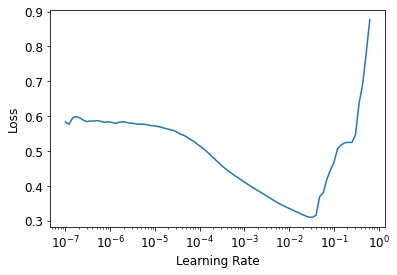

In [14]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

learn.lr_find() #find best lr

In [15]:
learn.fit_one_cycle(5, 1e-2) #train

epoch,train_loss,valid_loss,time
0,0.058050,0.054965,00:14
1,0.047368,0.052232,00:14
2,0.041544,0.050312,00:14
3,0.035930,0.049067,00:14
4,0.031330,0.049272,00:14


In [17]:
#Functions will be using to calc error
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [18]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.221972

> This is actually very good

## Random Forest
Lets now create our random forest and compare it to our NN

### Tabular object

In [22]:
procs = [Categorify, FillMissing]
rf_to = TabularPandas(df_nn, procs, cat_nn, cont_nn, y_names=dep_var, splits=splits)

In [24]:
#Grab our x,y
xs,y = rf_to.train.xs,rf_to.train.y 
valid_xs,valid_y = rf_to.valid.xs,rf_to.valid.y

### Random Forest

In [25]:
#Method below creates our random forest and fits it
def rf(xs, y, n_estimators=40, max_samples=200_000, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                max_samples=max_samples, max_features=max_features,
                                min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [26]:
m = rf(xs, y) #Fitting

In [27]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.171432, 0.233555)

> So it seems our random forest preformed worse in comparison to the NN. Let's improve this by adding the NN embeddings!

# Adding embeddings 

In [19]:
learn.model.embeds[:5] #These are just some of the embedding within the NN

ModuleList(
  (0): Embedding(54, 15)
  (1): Embedding(5242, 194)
  (2): Embedding(7, 5)
  (3): Embedding(73, 18)
  (4): Embedding(4, 3)
)

**The function below extracts the embeddings from the model**

In [28]:
def embed_features(learner, xs):
    xs = xs.copy()
    for i, feature in enumerate(learn.dls.cat_names):
        emb = learner.model.embeds[i].cpu()
        new_feat = pd.DataFrame(emb(tensor(xs[feature], dtype=torch.int64)), index=xs.index, columns=[f'{feature}_{j}' for j in range(emb.embedding_dim)])
        xs.drop(columns=feature, inplace=True)
        xs = xs.join(new_feat)
    return xs

In [29]:
#Extracting embeddings
embeded_xs = embed_features(learn, learn.dls.train.xs)
xs_valid = embed_features(learn, learn.dls.valid.xs)

In [30]:
embeded_xs.shape, xs_valid.shape

((404710, 907), (7988, 907))

### Fitting embeddings
Now that we have our embeddings, lets fit it into the random forest.

In [31]:
m = rf(embeded_xs, y) #Fitting

In [33]:
m_rmse(m, embeded_xs, y), m_rmse(m, xs_valid, valid_y)

(0.14817, 0.228745)

> It seems that adding the NN embeddings improves the random forest!